In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [57]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
from data_analysis_utils_trigger_rate import *
# import supervised_classification as supc    

In [3]:
inverse_means_map = np.load('/home/spbproc/euso-spb-patt-reco-v1/resources/inverse_flat_average_directions_4m_flipud.npy')

In [4]:
model_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20190409'
data_snippets_dir = 'ver4_machine_learning_flight_classification_tsne_cfg3_20190409'

os.makedirs(data_snippets_dir, exist_ok=True)

In [5]:
subset_classification_slug = 'ver4_ml_tsne_cfg3_20190409'

# Selecting the flight data

In [6]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls,
    readonly=False
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

## Columns

In [7]:
rfecv_selector_on_extra_trees__column_names = []

columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
print(columns_list_file_pathname)
with open(columns_list_file_pathname, 'r') as columns_list_file:
    rfecv_selector_on_extra_trees__column_names = columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20190409/rfecv_selector_on_extra_trees__column_names.txt


In [8]:
rfecv_selector_on_extra_trees__column_names__special = []

special_columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
print(special_columns_list_file_pathname)
with open(special_columns_list_file_pathname, 'r') as special_columns_list_file:
    rfecv_selector_on_extra_trees__column_names__special = special_columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20190409/rfecv_selector_on_extra_trees__column_names__special.txt


In [9]:
# This should be empty for now
rfecv_selector_on_extra_trees__column_names__special

[]

In [10]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=[
        ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
        ('gps_datetime_min')
    ] + rfecv_selector_on_extra_trees__column_names
)

classification_flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=rfecv_selector_on_extra_trees__column_names
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- sum
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- sum
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- sum
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_gps_datetime
	- min

spb_processing_v4_flatmap.event_trg_x_y_clusters
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_x_clusters
	- sizes_min
	- sizes_max
	- max_size_clu_height
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_y_clusters
	- sizes_min
	- sizes_max
	- max_size_clu_height
	- max_peak_clu_height
	- max_peak_clu_size

spb_processi

WARNING: not selecting NULL trg lines

## Event classes

In [11]:
EVENT_CLASSES = {
    'dot': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_dots': 6,
    'bg_increased_suddenly': 10,
    'persistent_dot': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_dots': 17,
    'dot_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_week_dot': 21,
    #
    'unclassified': -1
}

In [12]:
len(EVENT_CLASSES)

23

In [13]:
INVERSE_EVENT_CLASSES = {v: k for k, v in EVENT_CLASSES.items()}

## Constructing the query

In [14]:
classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'

current_columns_for_analysis_dict = flight_columns_for_analysis_dict

flight_select_clause_str, flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
    **current_columns_for_analysis_dict,
    classification_table_name: ['class_number']
})

flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(flight_tables_list)

flight_source_data_type_num = 1

flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) < 20
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
'''

for table, cols_list in classification_flight_columns_for_analysis_dict.items():
    for col in cols_list:
        flight_where_clauses_str += ' AND {}.{} IS NOT NULL\n'.format(table, col)

flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=flight_source_data_type_num,
    select_additional=flight_select_clause_str, 
    join_additional=flight_clauses_str,
    where_additional=flight_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, limit=350000,
    base_select='')

In [15]:
print(flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean_gz AS trg_box_per_gtu_mean_gz, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_per_gtu_sum, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.mean AS trg_pmt_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.mean_gz

In [16]:
flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [17]:
manual_classification_class_number_column = 'manual_classification_class_number'

In [18]:
flight_df.loc[flight_df[manual_classification_class_number_column].isnull(), 
              manual_classification_class_number_column] = -1

In [19]:
len(flight_df)

109301

In [20]:
manual_classification_class_name_column = 'manual_classification_class_name'

In [21]:
flight_df[manual_classification_class_name_column] = 'unclassified'
for class_name, class_number in EVENT_CLASSES.items():
    flight_df.loc[flight_df[manual_classification_class_number_column]==class_number, 
                  manual_classification_class_name_column] = class_name

In [22]:
flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_size,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr1_line_clusters_sizes_max,alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_size,manual_classification_class_number,manual_classification_class_name
0,61,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,39,0,39,11,7.0,...,74,74,4.60184,5.41446,5.14926,27,27,27,-1.0,unclassified
1,67,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,166,1,38,11,7.0,...,38,38,1.70155,2.29509,3.20554,35,35,35,-1.0,unclassified
2,73,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,39,0,39,22,7.0,...,26,26,5.69936,5.69849,1.11428,46,46,46,-1.0,unclassified
3,75,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,162,1,34,15,526.0,...,9,9,8.84120,8.84120,9.34996,10,10,10,-1.0,unclassified
4,77,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170430-072445...,trn_20170430-072445-001.001_C_inverse_flat_ave...,38,0,38,33,668.0,...,931,931,15.53590,13.86160,16.24120,944,944,944,-1.0,unclassified


In [23]:
flight_df[rfecv_selector_on_extra_trees__column_names].head()

,trg_box_per_gtu_max,trg_box_per_gtu_sum,trg_box_per_gtu_mean,trg_pmt_per_gtu_sum,trg_pmt_per_gtu_mean,trg_ec_per_gtu_sum,trg_ec_per_gtu_mean,trg_x_y_clusters_sizes_min,trg_x_y_clusters_sizes_max,trg_x_y_clusters_clu_areas_max,...,alt1_x_y_hough_peak_thr3_major_line_phi,alt1_gtu_x_hough_peak_thr1_major_line_rho,alt1_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_size,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr1_line_clusters_sizes_max,alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_size
0,7.0,9.0,0.818182,3.0,0.272727,3.0,0.272727,1,7,9,...,1.448210,4.74049,74,74,4.60184,5.41446,5.14926,27,27,27
1,7.0,15.0,1.363640,4.0,0.363636,3.0,0.272727,7,7,42,...,1.290240,2.31214,38,38,1.70155,2.29509,3.20554,35,35,35
2,7.0,22.0,1.000000,10.0,0.454545,10.0,0.454545,16,16,126,...,0.195124,2.44340,26,26,5.69936,5.69849,1.11428,46,46,46
3,526.0,1012.0,67.466700,68.0,4.533330,20.0,1.333330,592,592,2116,...,1.580070,9.05172,9,9,8.84120,8.84120,9.34996,10,10,10
4,668.0,8379.0,253.909000,638.0,19.333300,200.0,6.060610,940,940,2116,...,0.582123,16.28690,931,931,15.53590,13.86160,16.24120,944,944,944


In [24]:
np.count_nonzero(flight_df['event_id'].isnull())

0

In [25]:
flight_df['had_nan_fields'] = flight_df[rfecv_selector_on_extra_trees__column_names].isnull().any(axis=1)

In [26]:
np.count_nonzero(flight_df['had_nan_fields'])

0

In [27]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

In [28]:
len(flight_df_nonan)

109301

In [29]:
# TODO
# SELECT COUNT(*) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;
# SELECT COUNT( DISTINCT (source_file_acquisition, packet_id)) FROM spb_processing_v4_flatmap.event JOIN spb_processing_v4_flatmap.event_orig_x_y USING(event_id) WHERE source_data_type_num = 1 AND abs(gtu_in_packet-42) < 20 AND spb_processing_v4_flatmap.event_orig_x_y.count_nonzero > 256*6 LIMIT 5;


In [30]:
cur = event_v3_storage_provider_flight.connection.cursor()

In [31]:
cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 36 <= gtu_in_packet AND gtu_in_packet <= 60
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(*) FROM (
        SELECT DISTINCT source_file_acquisition, packet_id 
        FROM spb_processing_v4_flatmap.event WHERE source_data_type_num={source_data_type_num}
        AND 31 <= gtu_in_packet AND gtu_in_packet <= 67
    ) AS s
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_packets = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num}
'''.format(source_data_type_num=flight_source_data_type_num))
num_all_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 36 AND 60
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_36_60_events = cur.fetchone()[0]

cur.execute('''
    SELECT COUNT(event_id) FROM spb_processing_v4_flatmap.event 
    WHERE source_data_type_num={source_data_type_num} 
    AND gtu_in_packet BETWEEN 31 AND 67
'''.format(source_data_type_num=flight_source_data_type_num))
num_gtu_31_67_events = cur.fetchone()[0]

In [32]:
print('number of all         packets', num_all_packets)
print('number of gtu [36,60] packets', num_gtu_36_60_packets)
print('number of gtu [31,67] packets', num_gtu_31_67_packets)
print('-'*50)
print('number of all         events ', num_all_events)
print('number of gtu [36,60] events ', num_gtu_36_60_events)
print('number of gtu [31,67] events ', num_gtu_31_67_events)
print('-'*50)
print('sel. fraction of all         events {:.3f}'.format(len(flight_df_nonan) / num_all_events))
print('sel. fraction of gtu [36,60] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_36_60_events))
print('sel. fraction of gtu [31,67] events {:.3f}'.format(len(flight_df_nonan) / num_gtu_31_67_events))

number of all         packets 145648
number of gtu [36,60] packets 137363
number of gtu [31,67] packets 139935
--------------------------------------------------
number of all         events  243622
number of gtu [36,60] events  156135
number of gtu [31,67] events  167354
--------------------------------------------------
sel. fraction of all         events 0.449
sel. fraction of gtu [36,60] events 0.700
sel. fraction of gtu [31,67] events 0.653


# Applying models

This model does not use scaled data

In [33]:
# standard_scaler_on_train_rfecv_columns_pathname = \
#      os.path.join(model_data_snippets_dir, 'standard_scaler_on_train_rfecv_columns.pkl')
# standard_scaler_on_train_rfecv_columns = joblib.load(standard_scaler_on_train_rfecv_columns_pathname)

In [34]:
# flight__rfecv_columns_scaled_X = \
#     standard_scaler_on_train_rfecv_columns.transform(
#         flight_df[rfecv_selector_on_extra_trees__column_names].values)
# if np.count_nonzero(flight_df['had_nan_fields']) > 0:
#     flight_nonan__rfecv_columns_scaled_X = \
#         standard_scaler_on_train_rfecv_columns.transform(
#             flight_df_nonan[rfecv_selector_on_extra_trees__column_names].values)
# else:
#     flight_nonan__rfecv_columns_scaled_X = flight__rfecv_columns_scaled_X

## Extra trees classifier

In [35]:
flight_rfecv_columns__X  = flight_df_nonan[rfecv_selector_on_extra_trees__column_names].values

In [36]:
extra_trees_cls_on_train_rfecv__model_plk_pathname = \
    os.path.join(model_data_snippets_dir, 'extra_trees_cls_on_train_rfecv.pkl')
extra_trees_cls_on_train_rfecv_est = joblib.load(extra_trees_cls_on_train_rfecv__model_plk_pathname)

In [37]:
cls_column_base = 'extra_trees_cls_on_train_rfecv_est'
cls_column = cls_column_base + '_dropna'
cls_proba_column = 'extra_trees_cls_on_train_rfecv_est_dropna_proba'

In [38]:
# this might not be correct (but for this particular selection it should be fine becaus flight_df_nonan == flight_df )
flight_df[cls_column_base] = \
    extra_trees_cls_on_train_rfecv_est.predict(flight_rfecv_columns__X)

flight_df[cls_column] = \
    ((flight_df[cls_column_base]==1) & ~flight_df['had_nan_fields']).astype('int8')

In [39]:
flight_df[cls_proba_column] = np.nan
flight_df.loc[flight_df['event_id'].isin(flight_df_nonan['event_id']), cls_proba_column] = \
    extra_trees_cls_on_train_rfecv_est.predict_proba(flight_rfecv_columns__X)[:,1]

### Updating `flight_df_nonan` with classification predictions
(not in the report)

In [40]:
flight_df_nonan = flight_df[~flight_df['had_nan_fields']]

In [41]:
flight_df_nonan[rfecv_selector_on_extra_trees__column_names + ['manual_classification_class_number']].head()

,trg_box_per_gtu_max,trg_box_per_gtu_sum,trg_box_per_gtu_mean,trg_pmt_per_gtu_sum,trg_pmt_per_gtu_mean,trg_ec_per_gtu_sum,trg_ec_per_gtu_mean,trg_x_y_clusters_sizes_min,trg_x_y_clusters_sizes_max,trg_x_y_clusters_clu_areas_max,...,alt1_gtu_x_hough_peak_thr1_major_line_rho,alt1_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_size,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr1_line_clusters_sizes_max,alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_size,manual_classification_class_number
0,7.0,9.0,0.818182,3.0,0.272727,3.0,0.272727,1,7,9,...,4.74049,74,74,4.60184,5.41446,5.14926,27,27,27,-1.0
1,7.0,15.0,1.363640,4.0,0.363636,3.0,0.272727,7,7,42,...,2.31214,38,38,1.70155,2.29509,3.20554,35,35,35,-1.0
2,7.0,22.0,1.000000,10.0,0.454545,10.0,0.454545,16,16,126,...,2.44340,26,26,5.69936,5.69849,1.11428,46,46,46,-1.0
3,526.0,1012.0,67.466700,68.0,4.533330,20.0,1.333330,592,592,2116,...,9.05172,9,9,8.84120,8.84120,9.34996,10,10,10,-1.0
4,668.0,8379.0,253.909000,638.0,19.333300,200.0,6.060610,940,940,2116,...,16.28690,931,931,15.53590,13.86160,16.24120,944,944,944,-1.0


### Statistics of selected events

In [42]:
np.count_nonzero(flight_df[cls_column])

5312

In [43]:
np.count_nonzero(flight_df[cls_column])/len(flight_df)

0.048599738337252174

In [44]:
flight_df[[cls_column, cls_proba_column]].describe()

,extra_trees_cls_on_train_rfecv_est_dropna,extra_trees_cls_on_train_rfecv_est_dropna_proba
count,109301.000000,109301.000000
mean,0.048600,0.182547
std,0.215031,0.159021
min,0.000000,0.000000
25%,0.000000,0.058977
50%,0.000000,0.139791
75%,0.000000,0.266686
max,1.000000,1.000000


#### Events classified "air shower" - number of events by probability

In [45]:
for proba in np.arange(0.5, 1.0, 0.1):
    print('p > {:.2f}: {}'.format(proba, np.count_nonzero(flight_df[cls_proba_column] > proba)))

p > 0.50: 5312
p > 0.60: 2332
p > 0.70: 994
p > 0.80: 413
p > 0.90: 157


#### Events classified "air shower" - fraction of all events

In [46]:
np.count_nonzero(flight_df_nonan[cls_column])/num_all_events

0.021804270550278712

#### Events classified "air shower" - fraction of all events in gtu [36, 60]

In [47]:
np.count_nonzero(flight_df_nonan.query('gtu_in_packet >= 36 and gtu_in_packet <= 60')[cls_column])/num_gtu_36_60_events

0.03357991481730554

#### Packets classified "air shower" - fraction of all packets

In [48]:
num_cls_1_packets = \
    len(flight_df_nonan[flight_df_nonan[cls_column] == 1].groupby(
        ['source_file_acquisition', 'packet_id']).count()['event_id'])

In [49]:
num_cls_1_packets/num_all_packets

0.03644402944084368

#### Events classified "air shower" - fraction of all packets triggered in gtu [36, 60]

In [50]:
num_cls_1_gtu_36_60_packets = \
    len(flight_df_nonan[flight_df_nonan[cls_column] == 1] \
            .query('gtu_in_packet >= 36 and gtu_in_packet <= 60') \
            .groupby(['source_file_acquisition', 'packet_id']) \
            .count()['event_id'])

In [51]:
num_cls_1_gtu_36_60_packets/num_gtu_36_60_events

0.03357351010343613

### Distribution of classified events by date

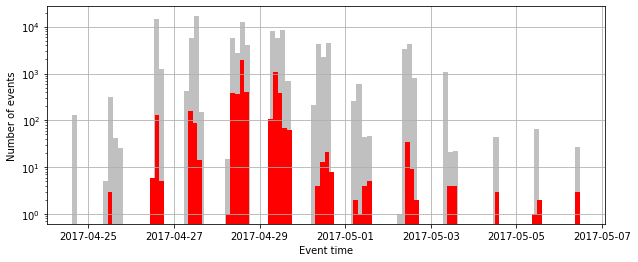

In [52]:
fig, ax = plt.subplots(figsize=(10,4))
flight_df_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver')
flight_df_nonan['gps_datetime_min'][flight_df_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red')
ax.set_yscale('log')
ax.set_ylabel('Number of events')
ax.set_xlabel('Event time')
plt.show()

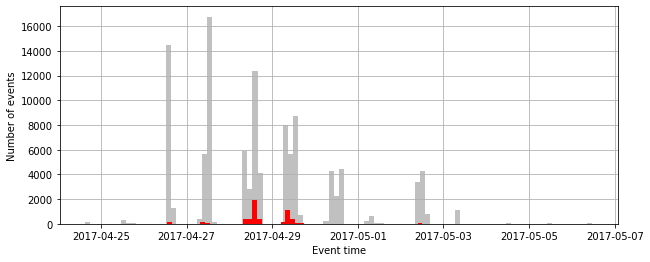

In [53]:
fig, ax = plt.subplots(figsize=(10,4))
flight_df_nonan['gps_datetime_min'].hist(ax=ax, bins=100, color='silver')
flight_df_nonan['gps_datetime_min'][flight_df_nonan[cls_column] == 1].hist(ax=ax, bins=100, color='red')
# ax.set_yscale('log')
ax.set_ylabel('Number of events')
ax.set_xlabel('Event time')
plt.show()

### Trigger rate

#### All flight HW events

In [54]:
# hw_trigger_num_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
hw_trigger_rate_per_file = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
hw_file_trigger_datetimes = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# hw_file_trigger_p_r = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# hw_file_trigger_timedelta = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# hw_file_indices = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

#### All bgf=0.5 events

In [55]:
# bgf05_trigger_num_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
bgf05_trigger_rate_per_file_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
bgf05_file_trigger_datetimes_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
# bgf05_file_trigger_p_r_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
# bgf05_file_trigger_timedelta_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
# bgf05_file_indices_list = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

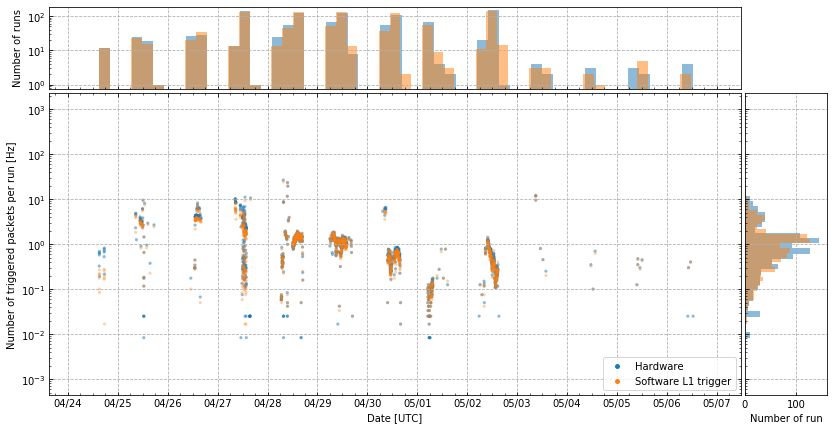

In [58]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )
# gray

vis_trigger_rate_w_distributions(
    bgf05_file_trigger_datetimes_list,
    bgf05_trigger_rate_per_file_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Software L1 trigger', color='C1', hist_alpha=.5, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_bgf05.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);
# dodgerblue

#### All classified events

In [59]:
all_classified_trigger_datetime_list, all_classified_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_nonan,  one_trg_per='packet')

1/987 allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root
2/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root
3/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root
4/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root
5/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root
6/987 allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root
7/987 allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root
8/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-001.001--LONG.root
9/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-002.001--LONG.root
10/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-003.001--LONG.root
11/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-004.001--LONG.root
12/987 allpackets-SPBEUSO-ACQUISITION-20170424-172427-005.001--LONG.root
13/987 allpackets-SPBEUSO-ACQUISITION-20170425-104043-001.001--CHECK.root
14/987 allpackets-SPBEUSO-ACQUISITION-20170425-104127-002

116/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-003.001--LONG-sqz.root
117/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-004.001--LONG-sqz-dis.root
118/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-004.001--LONG-sqz.root
119/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-005.001--LONG-sqz-dis.root
120/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-005.001--LONG-sqz.root
121/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-006.001--LONG-sqz-dis.root
122/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-006.001--LONG-sqz.root
123/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-007.001--LONG-sqz-dis.root
124/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-007.001--LONG-sqz.root
125/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-008.001--LONG-sqz-dis.root
126/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-008.001--LONG-sqz.root
127/987 allpackets-SPBEUSO-ACQUISITION-20170427-115303-009.001--LONG-sqz-dis.root
128/987 allpackets-SPBEUSO-ACQUISITION-2

221/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-028.001--LONG-sqz.root
222/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-029.001--LONG-sqz-dis.root
223/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-029.001--LONG-sqz.root
224/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-030.001--LONG-sqz-dis.root
225/987 allpackets-SPBEUSO-ACQUISITION-20170427-125407-030.001--LONG-sqz.root
226/987 allpackets-SPBEUSO-ACQUISITION-20170427-154845-001.001--CHECK.root
227/987 allpackets-SPBEUSO-ACQUISITION-20170427-162053-001.001--.root
 > SKIPPING
228/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-009.001--LONG.root
229/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-010.001--LONG.root
230/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-013.001--LONG.root
231/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-014.001--LONG.root
232/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-015.001--LONG.root
233/987 allpackets-SPBEUSO-ACQUISITION-20170428-063224-017.001--LONG.root
2

333/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-012.001--LONG.root
334/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-013.001--LONG.root
335/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-014.001--LONG.root
336/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-015.001--LONG.root
337/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-016.001--LONG.root
338/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-017.001--LONG.root
339/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-018.001--LONG.root
340/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-019.001--LONG.root
341/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-020.001--LONG.root
342/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-021.001--LONG.root
343/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-022.001--LONG.root
344/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-023.001--LONG.root
345/987 allpackets-SPBEUSO-ACQUISITION-20170428-140915-024.001--LONG.root
346/987 allpackets-SPBEUSO-ACQUISITION

448/987 allpackets-SPBEUSO-ACQUISITION-20170429-090155-001.001--CHECK.root
449/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-001.001--LONG-sqz.root
450/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-001.001--LONG.root
451/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-003.001--LONG.root
452/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-005.001--LONG-sqz.root
453/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-005.001--LONG.root
454/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-007.001--LONG.root
455/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-009.001--LONG-sqz.root
456/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-014.001--LONG-sqz.root
457/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-017.001--LONG-sqz.root
458/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-020.001--LONG.root
459/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-022.001--LONG.root
460/987 allpackets-SPBEUSO-ACQUISITION-20170429-090239-023.001--LONG-sqz.root
461/987 allpa

555/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-012.001--LONG-sqz.root
556/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-013.001--LONG-sqz.root
557/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-014.001--LONG-sqz.root
558/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-015.001--LONG-sqz.root
559/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-016.001--LONG-sqz.root
560/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-017.001--LONG-sqz.root
561/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-018.001--LONG-sqz.root
562/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-019.001--LONG-sqz.root
563/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-020.001--LONG-sqz.root
564/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-021.001--LONG-sqz.root
565/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-022.001--LONG-sqz.root
566/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-023.001--LONG-sqz.root
567/987 allpackets-SPBEUSO-ACQUISITION-20170429-130657-024.001--

679/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-003.001--LONG-sqz.root
680/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-004.001--LONG-sqz.root
681/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-005.001--LONG-sqz.root
682/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-006.001--LONG-sqz.root
683/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-007.001--LONG-sqz.root
684/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-008.001--LONG-sqz.root
685/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-009.001--LONG-sqz.root
686/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-010.001--LONG-sqz.root
687/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-011.001--LONG-sqz.root
688/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-012.001--LONG-sqz.root
689/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-013.001--LONG-sqz.root
690/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-014.001--LONG-sqz.root
691/987 allpackets-SPBEUSO-ACQUISITION-20170430-133603-016.001--

821/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-003.001--LONG-sqz.root
822/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-004.001--LONG-sqz.root
823/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-005.001--LONG-sqz.root
824/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-006.001--LONG-sqz.root
825/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-007.001--LONG-sqz.root
826/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-008.001--LONG-sqz.root
827/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-009.001--LONG-sqz.root
828/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-010.001--LONG-sqz.root
829/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-011.001--LONG-sqz.root
830/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-012.001--LONG-sqz.root
831/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-013.001--LONG-sqz.root
832/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-014.001--LONG-sqz.root
833/987 allpackets-SPBEUSO-ACQUISITION-20170502-094518-015.001--

931/987 allpackets-SPBEUSO-ACQUISITION-20170502-124806-021.001--LONG-sqz.root
932/987 allpackets-SPBEUSO-ACQUISITION-20170502-124806-022.001--LONG-sqz.root
933/987 allpackets-SPBEUSO-ACQUISITION-20170502-124806-023.001--LONG-sqz.root
934/987 allpackets-SPBEUSO-ACQUISITION-20170502-124806-024.001--LONG-sqz.root
935/987 allpackets-SPBEUSO-ACQUISITION-20170502-124806-025.001--LONG-sqz.root
936/987 allpackets-SPBEUSO-ACQUISITION-20170502-124806-026.001--LONG-sqz.root
937/987 allpackets-SPBEUSO-ACQUISITION-20170502-124806-027.001--LONG-sqz.root
938/987 allpackets-SPBEUSO-ACQUISITION-20170502-124806-028.001--LONG-sqz.root
939/987 allpackets-SPBEUSO-ACQUISITION-20170502-124806-029.001--LONG-sqz.root
940/987 allpackets-SPBEUSO-ACQUISITION-20170502-124806-030.001--LONG-sqz.root
941/987 allpackets-SPBEUSO-ACQUISITION-20170502-134817-001.001--CHECK.root
942/987 allpackets-SPBEUSO-ACQUISITION-20170502-134901-001.001--LONG-sqz.root
943/987 allpackets-SPBEUSO-ACQUISITION-20170502-134901-002.001--LON

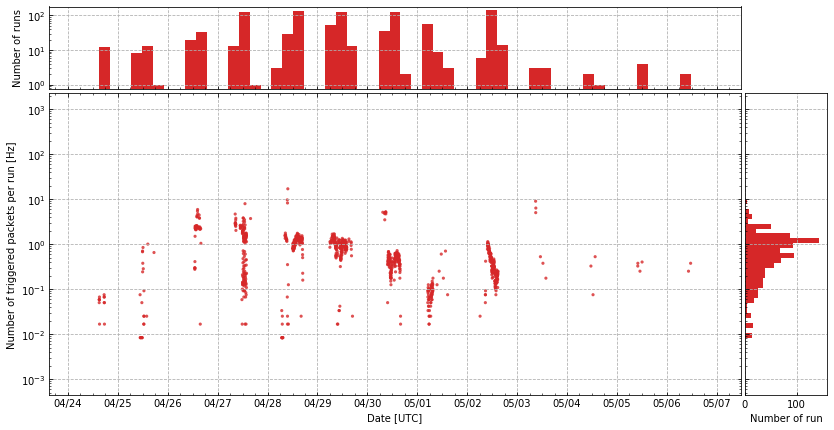

In [60]:
vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C3',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_all.png')
);
# limegreen

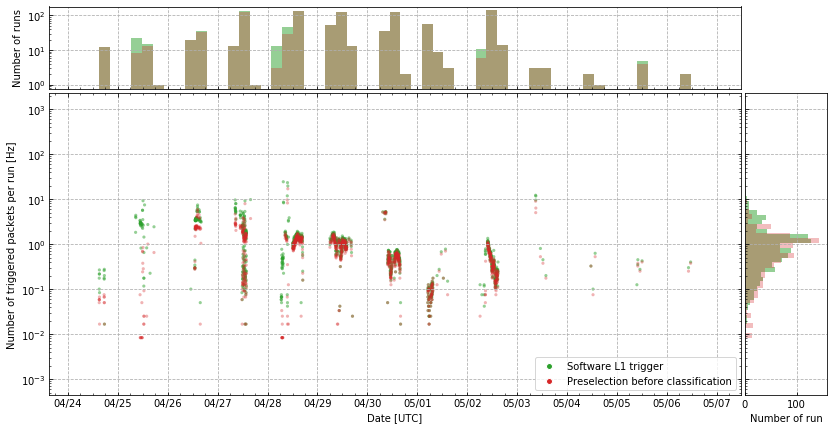

In [61]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        bgf05_file_trigger_datetimes_list,
        bgf05_trigger_rate_per_file_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Software L1 trigger', color='C2', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )
#dodgerblue

vis_trigger_rate_w_distributions(
    all_classified_trigger_datetime_list, 
    all_classified_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Preselection before classification', color='C3', hist_alpha=.3, scatter_alpha=.35,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_bgf05_vs_classified.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

#### Events classified as "air shower"

In [62]:
shower_trigger_datetime_list, shower_trigger_rate_list = \
    count_trigger_rate_per_file_from_df(flight_df_nonan[flight_df_nonan[cls_column] == 1],  one_trg_per='packet')

1/462 allpackets-SPBEUSO-ACQUISITION-20170425-104127-002.001--LONG.root
2/462 allpackets-SPBEUSO-ACQUISITION-20170425-115921-004.001--LONG.root
3/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-002.001--LONG.root
4/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-005.001--LONG.root
5/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-006.001--LONG.root
6/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-007.001--LONG.root
7/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-008.001--LONG.root
8/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-009.001--LONG.root
9/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-010.001--LONG.root
10/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-011.001--LONG.root
11/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-012.001--LONG.root
12/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-013.001--LONG.root
13/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-014.001--LONG.root
14/462 allpackets-SPBEUSO-ACQUISITION-20170426-125930-015.00

109/462 allpackets-SPBEUSO-ACQUISITION-20170428-081726-012.001--LONG.root
110/462 allpackets-SPBEUSO-ACQUISITION-20170428-081726-016.001--LONG.root
111/462 allpackets-SPBEUSO-ACQUISITION-20170428-081726-017.001--LONG.root
112/462 allpackets-SPBEUSO-ACQUISITION-20170428-081726-024.001--LONG.root
113/462 allpackets-SPBEUSO-ACQUISITION-20170428-081726-025.001--LONG.root
114/462 allpackets-SPBEUSO-ACQUISITION-20170428-081726-026.001--LONG.root
115/462 allpackets-SPBEUSO-ACQUISITION-20170428-081726-030.001--LONG.root
116/462 allpackets-SPBEUSO-ACQUISITION-20170428-091746-001.001--CHECK.root
117/462 allpackets-SPBEUSO-ACQUISITION-20170428-092901-001.001--LONG.root
118/462 allpackets-SPBEUSO-ACQUISITION-20170428-094402-001.001--LONG.root
119/462 allpackets-SPBEUSO-ACQUISITION-20170428-100047-001.001--CHECK.root
120/462 allpackets-SPBEUSO-ACQUISITION-20170428-120623-001.001--CHECK.root
121/462 allpackets-SPBEUSO-ACQUISITION-20170428-120707-001.001--LONG.root
122/462 allpackets-SPBEUSO-ACQUISIT

263/462 allpackets-SPBEUSO-ACQUISITION-20170429-070031-017.001--LONG.root
264/462 allpackets-SPBEUSO-ACQUISITION-20170429-070031-019.001--LONG.root
265/462 allpackets-SPBEUSO-ACQUISITION-20170429-070031-020.001--LONG.root
266/462 allpackets-SPBEUSO-ACQUISITION-20170429-070031-021.001--LONG.root
267/462 allpackets-SPBEUSO-ACQUISITION-20170429-070031-025.001--LONG.root
268/462 allpackets-SPBEUSO-ACQUISITION-20170429-070031-026.001--LONG.root
269/462 allpackets-SPBEUSO-ACQUISITION-20170429-070031-027.001--LONG.root
270/462 allpackets-SPBEUSO-ACQUISITION-20170429-070031-028.001--LONG.root
271/462 allpackets-SPBEUSO-ACQUISITION-20170429-070031-029.001--LONG.root
272/462 allpackets-SPBEUSO-ACQUISITION-20170429-070031-030.001--LONG.root
273/462 allpackets-SPBEUSO-ACQUISITION-20170429-080051-001.001--CHECK.root
274/462 allpackets-SPBEUSO-ACQUISITION-20170429-080135-001.001--LONG.root
275/462 allpackets-SPBEUSO-ACQUISITION-20170429-080135-002.001--LONG.root
276/462 allpackets-SPBEUSO-ACQUISITIO

382/462 allpackets-SPBEUSO-ACQUISITION-20170430-095015-001.001--CHECK.root
383/462 allpackets-SPBEUSO-ACQUISITION-20170430-095101-004.001--LONG-sqz.root
384/462 allpackets-SPBEUSO-ACQUISITION-20170430-095101-011.001--LONG-sqz.root
385/462 allpackets-SPBEUSO-ACQUISITION-20170430-095101-013.001--LONG-sqz.root
386/462 allpackets-SPBEUSO-ACQUISITION-20170430-095101-020.001--LONG-sqz.root
387/462 allpackets-SPBEUSO-ACQUISITION-20170430-095101-030.001--LONG-sqz.root
388/462 allpackets-SPBEUSO-ACQUISITION-20170430-105121-001.001--CHECK.root
389/462 allpackets-SPBEUSO-ACQUISITION-20170430-105205-003.001--LONG-sqz.root
390/462 allpackets-SPBEUSO-ACQUISITION-20170430-105205-025.001--LONG-sqz.root
391/462 allpackets-SPBEUSO-ACQUISITION-20170430-105205-026.001--LONG-sqz.root
392/462 allpackets-SPBEUSO-ACQUISITION-20170430-115225-001.001--CHECK.root
393/462 allpackets-SPBEUSO-ACQUISITION-20170430-125414-008.001--LONG-sqz.root
394/462 allpackets-SPBEUSO-ACQUISITION-20170430-125414-011.001--LONG-sqz.

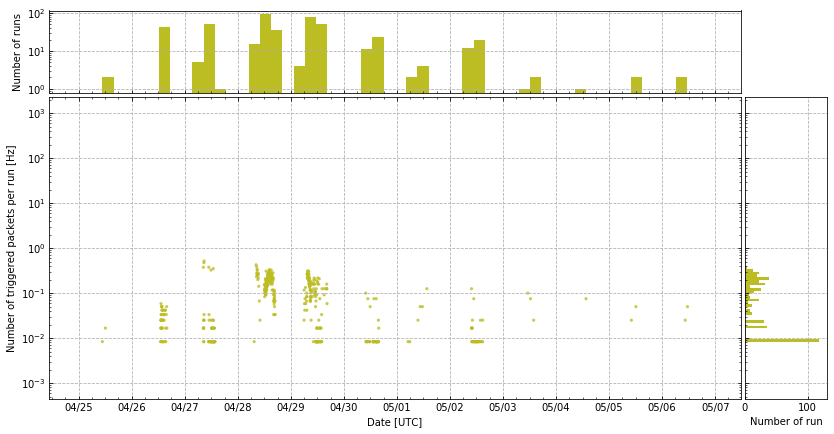

In [63]:
vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)),
    color='C8',
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_air_shower.png')
);

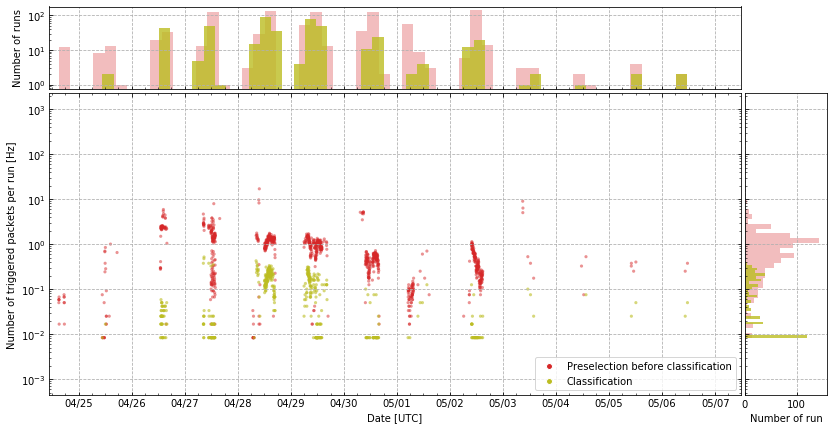

In [64]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        all_classified_trigger_datetime_list, 
        all_classified_trigger_rate_list,
        ylim=(10**(-2.5), 10**(2.5)),
        label='Preselection before classification', color='C3', hist_alpha=.3, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='C8', hist_alpha=.8, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_classified_vs_selected.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

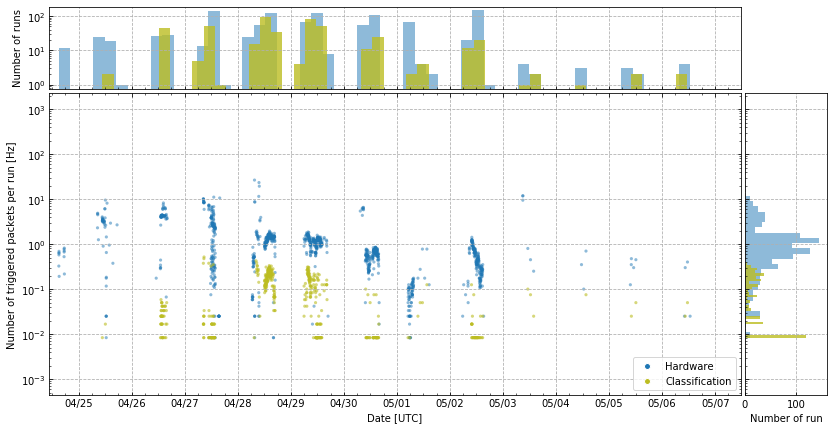

In [65]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='C0', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='C8', hist_alpha=.8, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_selected.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

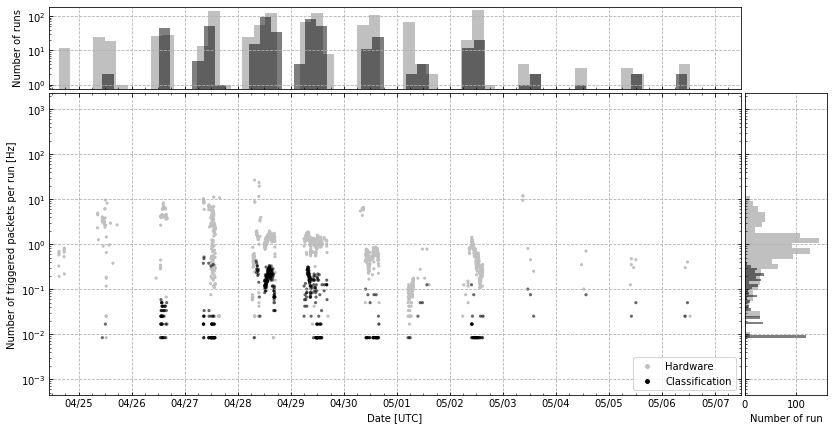

In [66]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        hw_file_trigger_datetimes,
        hw_trigger_rate_per_file, 
        ylim=(10**(-2.5), 10**(2.5)),
        label='Hardware', color='silver', hist_alpha=1, scatter_alpha=1,
        show=False
    )

vis_trigger_rate_w_distributions(
    shower_trigger_datetime_list, 
    shower_trigger_rate_list,
    ylim=(10**(-2.5), 10**(2.5)), 
    label='Classification', color='black', hist_alpha=.5, scatter_alpha=.6,
    base_figure_pathname=os.path.join(data_snippets_dir, 'trg_rate_1_per_packet_hw_vs_selected_bw.png'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

#### Summary - mean trigger rate

In [67]:
print('Mean trigger rate in hardware data:          ', np.mean(hw_trigger_rate_per_file))
print('Mean trigger rate in feature-extracted data: ', np.mean(bgf05_trigger_rate_per_file_list))
print('Mean trigger rate in classified data:        ', np.mean(all_classified_trigger_rate_list))
print('Mean trigger rate in classifer selected data:', np.mean(shower_trigger_rate_list))

Mean trigger rate in hardware data:           1.448051447935921
Mean trigger rate in feature-extracted data:  1.3001118568232661
Mean trigger rate in classified data:         0.9263860716700473
Mean trigger rate in classifer selected data: 0.10357142857142856


### Distribution of classified events

In [68]:
sns.set(style="whitegrid")

In [69]:
flight_df_nonan[manual_classification_class_name_column].value_counts()

unclassified              107444
dot                          365
top_left_ec                  295
blob                         270
bg_increased_suddenly        193
large_blob                   130
dot_w_blob_behind            123
few_dots                      84
bright_blob                   77
noise                         65
short_single_gtu_track        53
single_gtu_track              51
persistent_dot                29
unspecified                   22
2pix_line                     22
noise_unspecified             21
blob_and_dots                 15
cartesian_line                15
sparse_blobs                  12
noise_with_week_dot           12
storng_light                   3
Name: manual_classification_class_name, dtype: int64

Withount unclassified
All flight data in the selection


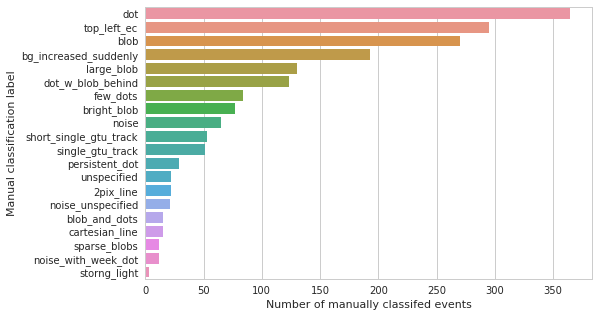

Events classified as positive


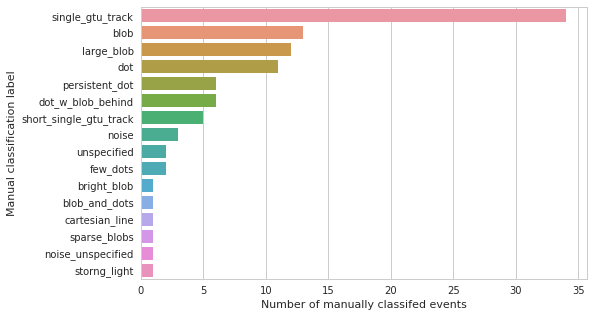

With unclassified
All flight data in the selection


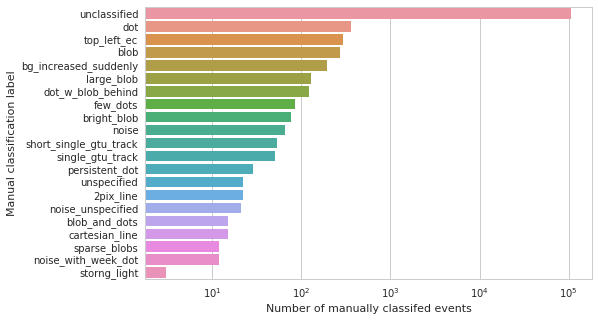

Events classified as positive


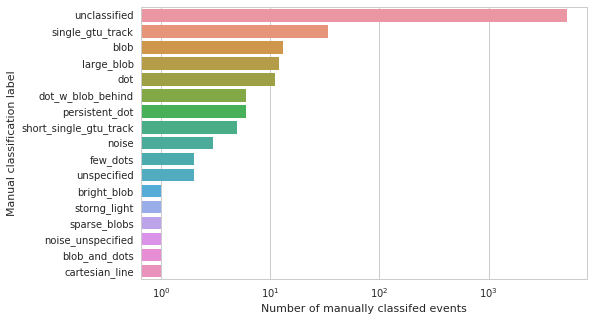

In [70]:
# requires manual_classification_class_name_column

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))
    
    for apply_air_shower_filter in [False, True]:
    
        print('Events classified as positive' if apply_air_shower_filter else 'All flight data in the selection')
    
        subset_df = \
            flight_df_nonan[flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']] \
            if not w_unclassified else \
            flight_df_nonan
    
        subset_df = subset_df[subset_df[cls_column] == 1] \
            if apply_air_shower_filter else subset_df
    
        fig, ax = plt.subplots(1, figsize=(8,5))
        sns.countplot(y=manual_classification_class_name_column, 
                      data=subset_df, ax=ax, orient='v',
                      order=subset_df[manual_classification_class_name_column].value_counts().index
                     )
        
        ax.set_ylabel('Manual classification label')
        ax.set_xlabel('Number of manually classifed events')

        flight_data_manual_classification_class_name_dist_fig_pathname = \
            os.path.join(
                data_snippets_dir, 
                'flight_data_manual_classification_class_name_distribution{}{}.svg'.format(
                    '_with_unclassified' if w_unclassified else '',
                    '_positive' if apply_air_shower_filter else ''
                ))

        if w_unclassified:
            ax.set_xscale('log')

        fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
        plt.show()
    
    print('='*50)

In [71]:
w_unclassified = False
apply_air_shower_filter = True

subset_df = \
    flight_df_nonan[
        flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
    ] if not w_unclassified else flight_df_nonan

print('All flight data in the selection')
print(subset_df.groupby([manual_classification_class_name_column])['event_id'].count())
print('-'*50)
print('Events classified as positive')
print(subset_df[subset_df[cls_column] == 1].groupby([manual_classification_class_name_column])['event_id'].count())
print('-'*50)
print('Ratios')

flight_data_nonan_class_ratios_df = \
    subset_df.groupby([manual_classification_class_name_column])[cls_column] \
        .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)

flight_data_nonan_class_ratios_df #[flight_data_nonan_class_ratios_df[cls_column] == 1]

All flight data in the selection
manual_classification_class_name
2pix_line                  22
bg_increased_suddenly     193
blob                      270
blob_and_dots              15
bright_blob                77
cartesian_line             15
dot                       365
dot_w_blob_behind         123
few_dots                   84
large_blob                130
noise                      65
noise_unspecified          21
noise_with_week_dot        12
persistent_dot             29
short_single_gtu_track     53
single_gtu_track           51
sparse_blobs               12
storng_light                3
top_left_ec               295
unspecified                22
Name: event_id, dtype: int64
--------------------------------------------------
Events classified as positive
manual_classification_class_name
blob                      13
blob_and_dots              1
bright_blob                1
cartesian_line             1
dot                       11
dot_w_blob_behind          6
few_dots         

,manual_classification_class_name,extra_trees_cls_on_train_rfecv_est_dropna,percentage
0,2pix_line,0,100.000000
25,short_single_gtu_track,0,90.566038
20,noise_unspecified,0,95.238095
18,noise,0,95.384615
34,unspecified,0,90.909091
16,large_blob,0,90.769231
14,few_dots,0,97.619048
28,single_gtu_track,0,33.333333
12,dot_w_blob_behind,0,95.121951
22,noise_with_week_dot,0,100.000000


Withount unclassified


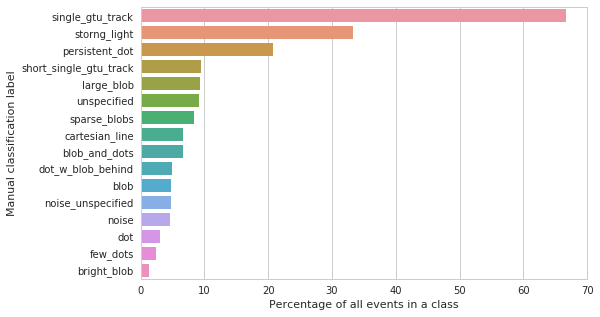

With unclassified


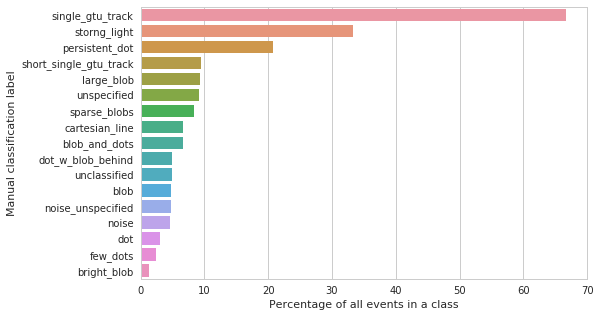

In [72]:
# flight_data_nonan_class_ratios_df

for w_unclassified in [False, True]:
    
    print('{} unclassified'.format('With' if w_unclassified else 'Withount'))

    subset_df = \
        flight_df_nonan[
            flight_df_nonan[manual_classification_class_number_column] != EVENT_CLASSES['unclassified']
        ] if not w_unclassified else flight_df_nonan

    flight_data_nonan_class_ratios_df = \
        subset_df.groupby([manual_classification_class_name_column])[cls_column] \
            .value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values(cls_column)

    fig, ax = plt.subplots(1, figsize=(8,5))

    subset_df = flight_data_nonan_class_ratios_df[flight_data_nonan_class_ratios_df[cls_column] == 1]
    
    p = sns.barplot(y=manual_classification_class_name_column, 
                    x="percentage", #hue=cls_column, 
                    data=subset_df, 
                    ax=ax, orient='h',
                    order=subset_df[manual_classification_class_name_column].iloc[
                        np.argsort(-subset_df["percentage"])]
                   )

    ax.set_ylabel('Manual classification label')
    ax.set_xlabel('Percentage of all events in a class')

    flight_data_manual_classification_class_name_dist_fig_pathname = \
        os.path.join(
            data_snippets_dir, 
            'flight_data_manual_classification_class_name_normalized_distribution{}.svg'.format(
                '_with_unclassified' if w_unclassified else ''
            ))

#     if w_unclassified:
#         ax.set_xscale('log')

    fig.savefig(flight_data_manual_classification_class_name_dist_fig_pathname, dpi=150)
    plt.show()

In [73]:
mpl.rcParams.update(mpl.rcParamsDefault)

### Saving flight data into tsv
(not in the report)

In [74]:
save_flight_data_dump_file = True
overwrite_flight_data_dump_file = False

In [75]:
if save_flight_data_dump_file:
    flight_data_tsv_pathname = os.path.join(data_snippets_dir, 'flight_data.tsv.gz')

    if overwrite_flight_data_dump_file or not os.path.exists(flight_data_tsv_pathname):
        print('Saving', flight_data_tsv_pathname)
        flight_df.to_csv(flight_data_tsv_pathname, sep='\t', compression='gzip')
    else:
        print('Already exists', flight_data_tsv_pathname)

Already exists ver4_machine_learning_flight_classification_tsne_cfg3_20190409/flight_data.tsv.gz


# Visualization of the events

## Visualizing the features

In [76]:
flight_df_nonan[rfecv_selector_on_extra_trees__column_names + ['manual_classification_class_number']].head()

,trg_box_per_gtu_max,trg_box_per_gtu_sum,trg_box_per_gtu_mean,trg_pmt_per_gtu_sum,trg_pmt_per_gtu_mean,trg_ec_per_gtu_sum,trg_ec_per_gtu_mean,trg_x_y_clusters_sizes_min,trg_x_y_clusters_sizes_max,trg_x_y_clusters_clu_areas_max,...,alt1_gtu_x_hough_peak_thr1_major_line_rho,alt1_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_size,alt1_gtu_x_hough_peak_thr2_major_line_rho,alt1_gtu_x_hough_peak_thr3_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr1_line_clusters_sizes_max,alt1_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_size,manual_classification_class_number
0,7.0,9.0,0.818182,3.0,0.272727,3.0,0.272727,1,7,9,...,4.74049,74,74,4.60184,5.41446,5.14926,27,27,27,-1.0
1,7.0,15.0,1.363640,4.0,0.363636,3.0,0.272727,7,7,42,...,2.31214,38,38,1.70155,2.29509,3.20554,35,35,35,-1.0
2,7.0,22.0,1.000000,10.0,0.454545,10.0,0.454545,16,16,126,...,2.44340,26,26,5.69936,5.69849,1.11428,46,46,46,-1.0
3,526.0,1012.0,67.466700,68.0,4.533330,20.0,1.333330,592,592,2116,...,9.05172,9,9,8.84120,8.84120,9.34996,10,10,10,-1.0
4,668.0,8379.0,253.909000,638.0,19.333300,200.0,6.060610,940,940,2116,...,16.28690,931,931,15.53590,13.86160,16.24120,944,944,944,-1.0


### Features used by the model

In [77]:
len(rfecv_selector_on_extra_trees__column_names)

199

In [78]:
importances = extra_trees_cls_on_train_rfecv_est.feature_importances_
indices = np.argsort(importances)[::-1]


rfecv_selector_on_extra_trees__column_names_indices_importances__sorted = \
    sorted(
        [
            (rfecv_selector_on_extra_trees__column_names[indices[f]], indices[f], importances[indices[f]]) \
            for f in range(len(rfecv_selector_on_extra_trees__column_names)) 
        ], 
        key=lambda e: e[2],
        reverse=True
    )

for column_name, column_indice, column_importance in \
        rfecv_selector_on_extra_trees__column_names_indices_importances__sorted:
    print('{:<70}{:.4f}'.format(column_name,column_importance))


rfecv_selector_on_extra_trees__column_names__sorted = \
    [e[0] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

rfecv_selector_on_extra_trees__column_indices__sorted = \
    [e[1] for e in rfecv_selector_on_extra_trees__column_names_indices_importances__sorted]

trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_width              0.0437
trg_x_y_hough_peak_thr1_line_clusters_clu_widths_max                  0.0280
proc2_x_y_hough_peak_thr1_line_clusters_count                         0.0263
alt1_x_y_hough_peak_thr1_line_clusters_max_area_clu_width             0.0240
trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_width              0.0237
proc3_x_y_hough_peak_thr1_line_clusters_count                         0.0195
proc3_x_y_hough_peak_thr2_line_clusters_count                         0.0192
alt1_x_y_hough_peak_thr1_line_clusters_clu_widths_max                 0.0187
proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width             0.0182
proc3_x_y_hough_peak_thr1_line_clusters_max_size_clu_width            0.0180
trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width            0.0173
trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width               0.0173
proc2_x_y_hough_peak_thr1_line_clusters_clu_widths_max                0.0166

In [79]:
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
#event_v3_storage_provider_flight.connection.reset()

In [ ]:
# flight_nonan_classified_shower_pathname = os.path.join(data_snippets_dir, 'flight_nonan_classified shower.tsv')

In [ ]:
# flight_df_nonan[flight_df_nonan['extra_trees_cls_on_train_kbest400_128_est_dropna']==1].to_csv(flight_nonan_classified_shower_pathname, sep='\t')

In [ ]:
# TODO select clusters with positive classification (sort by the number of classifications) show distribution of event types

In [ ]:

# flight_df_nonan_subset[['dbscan_tsne_y','manual_classification_class_number'].hist('dbscan_tsne_y', figsize=(24,4), bins=2*len(dbscan_on_tsne_classes)+1)

# plt.show()

In [ ]:
# THIS IS NOT WHAT IS DESIRED - values should be split into features ?
# flight_nonan__cls_tsneclu_corr_df = \
#     flight_df_nonan[['dbscan_tsne_y', 'manual_classification_class_number']].corr()
# f, ax = plt.subplots(figsize=(28,22))
# plt.close('all')
# sns.heatmap(flight_nonan__cls_tsneclu_corr_df, cmap='inferno', annot=True)
# plt.show()

In [ ]:
#     f, ax = plt.subplots()
#     f.set_size_inches(8,4)
#     flight_df_nonan_subset[['dbscan_tsne_y', 'manual_classification_class_number']].plot.bar(by='dbscan_tsne_y', ax=ax)
    

In [ ]:
# flight_nonan__tsne__gmm_y_pred = gmm.predict(flight_df_nonan[['tsne_X_0','tsne_X_1']].values)

In [ ]:
# flight_data__k50best_var_th_scaled_X = \
#     k50best_f_classif_selector_on_var_th_sc_train.transform(
#         var_th_selector_on_scaled_train.transform(
#             standard_scaler_on_train.transform(
#                 unl_flight_df[analyzed_common_df_columns].dropna().values)
#         )
#     )

# extra_trees_classifier_on_train_kbest50__X_flight = flight_data__k50best_var_th_scaled_X
# extra_trees_classifier_on_train_kbest50__y_flight_pred = \
#     extra_trees_classifier_on_train_kbest50.predict(extra_trees_classifier_on_train_kbest50__X_flight)